In [1]:
import numpy as np
import uproot
import math

In [2]:
tree = uproot.open( "mltree.root:Stg" )

In [3]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

In [5]:
xyztv = tree.arrays( [ "x", "y", "z", "tid", "vid" ], library='np'  )

array([-45.055008  ,  -0.917182  ,   7.5432425 ,  14.245992  ,
       -39.71492   ,  15.288912  ,  43.614513  ,  -0.9356067 ,
         8.502674  ,  16.450796  , -42.56439   ,  17.376654  ,
        17.393652  , -52.776825  ,  -0.9374285 ,   9.475048  ,
        18.730406  , -45.45975   , -15.406363  ,  19.412064  ,
        -0.95660293,  10.435221  ,  20.901785  , -48.378323  ,
        21.303198  ,  21.704903  ], dtype=float32)

In [11]:
class HitPoint:
    def __init__( self, _x, _y, _z, _v, _t ):
        self.x = _x
        self.y = _y
        self.z = _z
        self.v = _v
        self.t = _t
    def __repr__( self ):
        return 'HitPoint[v=%d, (%0.3f, %0.3f, %0.3f), tid=%d]' % ( self.v, self.x, self.y, self.z, self.t )
    
class CriteriaResult:
    def __init__(self):
        self.real = False
        self.res = -99
        self.pt = -99
        self.eta = -99
        self.phi = -99
    
        
def generate_vol_map( x, y, z, v, t, phi0, phi1 ):
    vol_map = [ [], [], [], [] ] # maps to 4 volumes
    for _x, _y, _z, _v, _t in zip(  x, y, z, v, t ):
        phi = math.atan2( _y, _x )
        if phi < phi1 and phi >= phi0 :
            vol_map[_v].append( HitPoint( _x, _y, _z, _v, _t ) )
    return vol_map
    #vol_map[]
    #print( len(x) )

def gen_pairs( vm ) :
    hp = []
    for i in np.arange( 0, 3 ):
        for a in vm[i] :
            for b in vm[i+1]:
                hp.append( (a,b) )
    return hp

def process_pairs( hp, pts, crit ):
    crs = []
    
    for points in hp:
        a = points[0]
        b = points[1]
        cr = CriteriaResult()
        cr.res = crit(a, b)
        cr.real = (a.t == b.t)
        if cr.real :
            cr.pt = pts[a.t - 1]
        crs.append( cr )
        
    return crs


def crit_rz( a, b ):
    dx = a.x-b.x
    dy = a.y-b.y
    dz = a.z-b.z
    return (dx**2+dy**2+dz**2)/dz**2;

M_PI = 3.1415926
def crit_dphi( a, b ):
    phia = math.atan2( a.y, a.x )
    phib = math.atan2(b.y, b.x)
    deltaPhi = phia-phib
    if deltaPhi > M_PI :
        deltaPhi = deltaPhi - 2*M_PI
    if deltaPhi < -M_PI:
        deltaPhi = deltaPhi + 2*M_PI
    if ( b.y*b.y + b.x*b.x < 0.0001 ) or ( a.y*a.y + a.x*a.x < 0.0001 ):
        deltaPhi = 0
    deltaPhi = 180. * math.fabs( deltaPhi ) / M_PI
    return deltaPhi

def crit_deltaRho( a, b ):
    rhoA =  math.sqrt( a.x*a.x + a.y*a.y );
    rhoB =  math.sqrt( b.x*b.x + b.y*b.y );

    deltaRho = rhoA - rhoB;
    return deltaRho

def pair_stats( pairs ):
    nr = 0
    nf = 0
    for p in pairs:
        if p[0].t == p[1].t:
            nr = nr + 1
        else :
            nf = nf + 1
#     print( "There are %d real and %d fake pairs, with %f %% real" % ( nr, nf, (nr / len(pairs)) ) ) 
    return (nr, nf, (nr / len(pairs)) )

In [14]:
all_pairs = []
real_pairs = []
fake_pairs = []

all_RZ = []
all_DP = []
all_DR = []

for iEvent in np.arange( len(xyztv["x"]) ) :
    vm = generate_vol_map( xyztv["x"][iEvent], xyztv["y"][iEvent], xyztv["z"][iEvent], xyztv["vid"][iEvent], xyztv["tid"][iEvent], 0, math.pi/8 )
    pairs = gen_pairs( vm )
    all_pairs.extend( pairs )
    
    if iEvent % 5000 == 0:
        print( "Event %d" %(iEvent))
#     inr, inf, ipur = pair_stats( pairs )

    

Event 0
Event 5000
Event 10000
Event 15000
Event 20000
Event 25000
Event 30000
Event 35000
Event 40000
Event 45000


In [15]:
all_RZ = [ crit_rz( p[0], p[1] ) for p in all_pairs ]

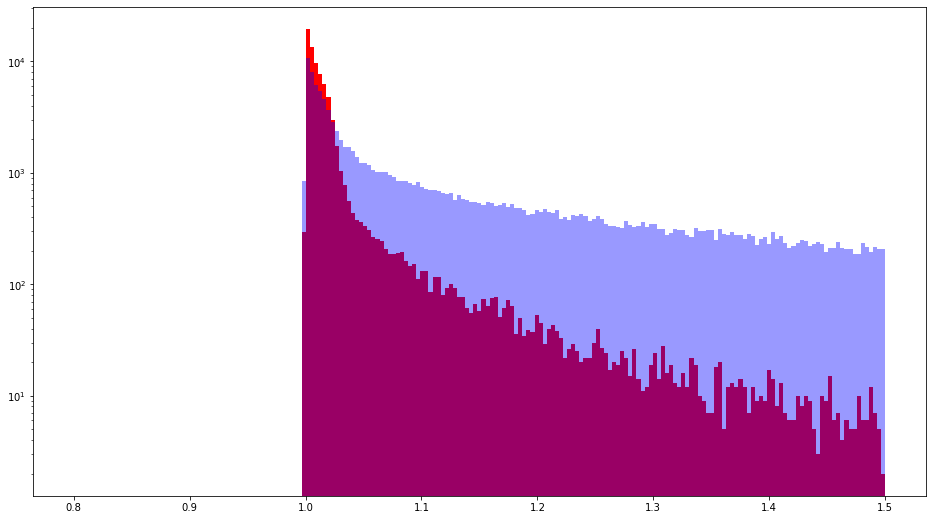

In [16]:
realtrack = [ True if p[0].t == p[1].t else False for p in all_pairs ]
RZ_real = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t == all_pairs[i][1].t  ]
RZ_fake = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t != all_pairs[i][1].t  ]

plt.figure(figsize=fs)
plt.hist( RZ_real, bins=np.linspace(0.8, 1.5, 200), fc='red' )
plt.hist( RZ_fake, bins=np.linspace(0.8, 1.5, 200), fc='blue', alpha=0.4 )
plt.yscale('log')
plt.show()